In [1]:
import numpy as np
import collections
import random
import copy
import numpy.linalg as la
import matplotlib.pyplot as plt

In [2]:
class MDP:
    def __init__(self, left, up, right, down, reward, gamma=0.99):
        self.actions = [left, up, right, down]
        self.reward = reward
        self.gamma = gamma
        self.state = list(range(1,82))

In [3]:
def loadMDP():
    with open('grid-world-environment/prob-a1.txt') as f:
        left = collections.defaultdict(dict)
        data = f.readlines()
        for prob in data:
            st, st1, p = prob.split()
            left[int(st)][int(st1)] = float(p)
    with open('grid-world-environment/prob-a2.txt') as f:
        up = collections.defaultdict(dict)
        data = f.readlines()
        for prob in data:
            st, st1, p = prob.split()
            up[int(st)][int(st1)] = float(p)
    with open('grid-world-environment/prob-a3.txt') as f:
        right = collections.defaultdict(dict)
        data = f.readlines()
        for prob in data:
            st, st1, p = prob.split()
            right[int(st)][int(st1)] = float(p)
    with open('grid-world-environment/prob-a4.txt') as f:
        down = collections.defaultdict(dict)
        data = f.readlines()
        for prob in data:
            st, st1, p = prob.split()
            down[int(st)][int(st1)] = float(p)
    with open('grid-world-environment/rewards.txt') as f:
        reward = dict()
        data = f.readlines()
        for i, r in enumerate(data):
            reward[i+1] = int(r)
    ret_mdp = MDP(left, up, right, down, reward)
    return ret_mdp

In [4]:
mdp = loadMDP()

Part1

In [5]:
def init_Q():
    Q = dict()
    for i in range(1, 82):
        Q[i] = np.zeros(4)
    return Q

In [6]:
def chooseAction(Q, mdp, currState, eps=0.2):
    if random.uniform(0,1) < eps:
        # explore, randomly choose next move
        nextState = currState
        while nextState == currState:
            choice = random.randint(0, len(mdp.actions[0][currState])-1)
            nextState = list(mdp.actions[0][currState].keys())[choice]
        if currState - 1 == nextState:
            return 1
        if currState - 9 == nextState:
            return 0
        if currState + 1 == nextState:
            return 3
        elif currState + 9 == nextState:
            return 2
    # exploit, pick the highest Q[state,action] move  
    max_prob = -1
    max_act = list()
    for nextState in mdp.actions[0][currState]:
        if nextState == currState:
            continue
        if currState - 1 == nextState:
            action =  1
        elif currState - 9 == nextState:
            action = 0
        elif currState + 1 == nextState:
            action = 3
        elif currState + 9 == nextState:
            action = 2
        if Q[currState][action] > max_prob:
            max_prob = Q[currState][action]
            max_act = list()
            max_act.append(action)
        elif Q[currState][action] == max_prob:
            max_act.append(action)
    return random.choice(max_act)

def processAction(mdp, currState, a):
    if a==0:
        # left
        nextState = currState - 9
    elif a==1:
        # up
        nextState = currState - 1
    elif a==2:
        # right
        nextState = currState + 9
    else:
        # down
        nextState = currState + 1
    rewardReceived = mdp.reward[nextState]
    playing = (nextState != 79 and nextState != 47 and nextState != 49 and nextState != 51 and nextState !=65 and nextState != 67 and nextState != 69)
    return nextState, rewardReceived, playing

In [42]:
def calc_change(old, new):
    old_matrix = np.zeros((81,4))
    new_matrix = np.zeros((81,4))
    for i in range(81):
        for j in range(4):
            old_matrix[i][j] = old[i+1][j]
            new_matrix[i][j] = new[i+1][j]
    return la.norm(old_matrix-new_matrix,'fro')

In [49]:
dQ = []
max_epoch = 40000
Q = init_Q()
alpha = 0.1
for i in range(max_epoch):
    playing = True
    state = 3
    prev_Q = copy.deepcopy(Q)
    while playing:
        action = chooseAction(Q, mdp, state, 0.7)
        newState, rewardReceived, playing = processAction(mdp, state, action)
        # update rule Q[state][action] = (1-alpha)Q[state][action] + alpha(reward + gamma Max(Q[newState][next_act]))
        Q[state][action] = (1-alpha)*Q[state][action] + alpha * (rewardReceived + mdp.gamma * np.max(Q[newState]))
        state = newState
    dQ.append(calc_change(prev_Q, Q))
    prev_Q = copy.deepcopy(Q)
    if i % 5000 == 4999:
        print('----------{}/{} Complete----------'.format(i+1, max_epoch))

----------5000/40000 Complete----------
----------10000/40000 Complete----------
----------15000/40000 Complete----------
----------20000/40000 Complete----------
----------25000/40000 Complete----------
----------30000/40000 Complete----------
----------35000/40000 Complete----------
----------40000/40000 Complete----------


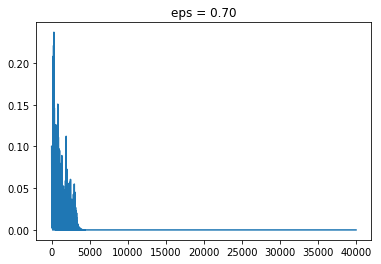

In [50]:
plt.plot(dQ)
plt.title('eps = 0.70')
plt.show()

In [39]:
def get_path(q):
    sq = 3
    path = [sq]
    try:
        while sq != 79:
            move = np.argmax(q[sq])
            if move == 0:
                sq -= 9
            elif move == 1:
                sq -=1
            elif move == 2:
                sq += 9
            else:
                sq += 1
            path.append(sq)
    except:
        return path
    return path

In [41]:
get_path(Q)

[3, 12, 11, 20, 29, 30, 39, 48, 57, 58, 59, 60, 61, 70, 79]

Part 2

In [51]:
def encodeState(currentState, c=0.01):
    # returns 82 dimensional vector
    vec = np.zeros(82)
    # state is 1-indexed
    vec[currentState-1] = 1
    vec[-1] = c
    return vec
def init_w():
    w = [np.zeros(82) for _ in range(4)]
    return w
def chooseAction_oh(w, mdp, currState, eps=0.2):
    if random.uniform(0,1) < eps:
        # explore, randomly choose next move
        nextState = currState
        while nextState == currState:
            choice = random.randint(0, len(mdp.actions[0][currState])-1)
            nextState = list(mdp.actions[0][currState].keys())[choice]
        if currState - 1 == nextState:
            return 1
        if currState - 9 == nextState:
            return 0
        if currState + 1 == nextState:
            return 3
        elif currState + 9 == nextState:
            return 2
    # exploit, pick the highest Q[state,action] move  
    max_prob = -float('inf')
    max_act = list()
    for nextState in mdp.actions[0][currState]:
        if nextState == currState:
            continue
        if currState - 1 == nextState:
            action =  1
        elif currState - 9 == nextState:
            action = 0
        elif currState + 1 == nextState:
            action = 3
        elif currState + 9 == nextState:
            action = 2
        if w[action].dot(encodeState(currState)) > max_prob:
            max_act = list()
            max_act.append(action)
            max_prob = w[action].dot(encodeState(currState))
        elif w[action].dot(encodeState(currState)) == max_prob:
            max_act.append(action)
    return random.choice(max_act)

In [52]:
dw = []
max_epoch = 10000
w = init_w()
prev = copy.deepcopy(w)
lr = 0.1
for i in range(max_epoch):
    playing = True
    state = 3
    state_vec = encodeState(state)
    while playing:
        action = chooseAction_oh(w, mdp, state)
        newState, rewardReceived, playing = processAction(mdp, state, action)
        newState_vec = encodeState(newState)
        # Update parameters using currentFeatVector, newFeatVector, and rewardReceived
        q = w[action].dot(state_vec)
        q_plus = rewardReceived + mdp.gamma * max([w[a].dot(newState_vec) for a in range(4)])
        best_action = np.argmax([w[a].dot(newState_vec) for a in range(4)])
        if best_action == action:
            dLoss = (q - q_plus) * (state_vec - mdp.gamma * newState_vec)
        else:
            dLoss = (q - q_plus) *  state_vec
        w[action] -= lr * dLoss
        state = newState
        state_vec = encodeState(state)
    change = 0
    for j in range(4):
        change += la.norm(prev[j]-w[j])
    dw.append(change)
    prev = copy.deepcopy(w)
    if i % 1000 == 999:
        print('----------{}/{} Complete----------'.format(i+1, max_epoch))

----------1000/10000 Complete----------
----------2000/10000 Complete----------
----------3000/10000 Complete----------
----------4000/10000 Complete----------
----------5000/10000 Complete----------
----------6000/10000 Complete----------
----------7000/10000 Complete----------
----------8000/10000 Complete----------
----------9000/10000 Complete----------
----------10000/10000 Complete----------


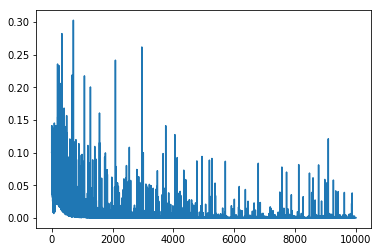

In [53]:
plt.plot(dw)

In [54]:
def get_path_vec(weights):
    sq = 3
    path = [3]
    while sq != 79:
        move = np.argmax([w[a].dot(encodeState(sq)) for a in range(4)])
        if move == 0:
            sq -= 9
        elif move == 1:
            sq -=1
        elif move == 2:
            sq += 9
        else:
            sq += 1
        path.append(sq)
    return path

In [55]:
get_path_vec(w)

[3, 12, 11, 20, 29, 30, 39, 48, 57, 58, 59, 60, 61, 70, 79]

Part 3

In [15]:
DRAGONS = [47,49,51,65,67,69]
def featureVector(sq, c=1):
    """distance, dragons, goal, bias"""
    # calc l1 dist
    temp = sq
    col = 0
    while temp + 9 < 79:
        col += 1
        temp += 9
    if temp == 79:
        dist = col
    elif temp > 81:
        if state % 9 == 0:
            dist = col + 2
        if state % 9 == 8:
            dist = col + 1
    else:
        dist = col + 79 - (temp - 9)
    # dragons
    dragon = 0
    if sq - 9 in DRAGONS:
        dragon += 1
    if sq + 9 in DRAGONS:
        dragon += 1
    if sq - 1 in DRAGONS:
        dragon += 1
    if sq + 1 in DRAGONS:
        dragon += 1
    # goal
    goal = 0
    if sq - 9 == 79 or sq + 9 == 79 or sq - 1 == 79 or sq + 1 == 79:
        goal = 1
    return np.array([dist, dragon, goal, c])
def init_fw():
    w = [np.zeros(4) for _ in range(4)]
    return w
def chooseAction_fv(fw, mdp, currState, eps=0.2):
    if random.uniform(0,1) < eps:
        # explore, randomly choose next move
        nextState = currState
        while nextState == currState:
            choice = random.randint(0, len(mdp.actions[0][currState])-1)
            nextState = list(mdp.actions[0][currState].keys())[choice]
        if currState - 1 == nextState:
            return 1
        if currState - 9 == nextState:
            return 0
        if currState + 1 == nextState:
            return 3
        elif currState + 9 == nextState:
            return 2
    # exploit, pick the highest Q[state,action] move  
    max_prob = -float('inf')
    max_act = list()
    for nextState in mdp.actions[0][currState]:
        if nextState == currState:
            continue
        if currState - 1 == nextState:
            action =  1
        elif currState - 9 == nextState:
            action = 0
        elif currState + 1 == nextState:
            action = 3
        elif currState + 9 == nextState:
            action = 2
        if fw[action].dot(featureVector(currState)) > max_prob:
            max_act = list()
            max_act.append(action)
            max_prob = fw[action].dot(featureVector(currState))
        elif fw[action].dot(featureVector(currState)) == max_prob:
            max_act.append(action)
    return random.choice(max_act)

In [16]:
dfw = []
max_epoch = 10
fw = init_fw()
fprev = copy.deepcopy(fw)
lr = 0.1
for i in range(max_epoch):
    playing = True
    state = 3
    state_vec = featureVector(state)
    while playing:
        action = chooseAction_fv(fw, mdp, state)
        newState, rewardReceived, playing = processAction(mdp, state, action)
        newState_vec = featureVector(newState)
        # Update parameters using currentFeatVector, newFeatVector, and rewardReceived
        q = fw[action].dot(state_vec)
        q_plus = rewardReceived + mdp.gamma * max([fw[a].dot(newState_vec) for a in range(4)])
        best_action = np.argmax([fw[a].dot(newState_vec) for a in range(4)])
        if best_action == action:
            dLoss = (q - q_plus) * (state_vec - mdp.gamma * newState_vec)
        else:
            dLoss = (q - q_plus) *  state_vec
        fw[action] -= lr * dLoss
        # avoid overflow, normalization
        norm = la.norm(fw[action]) if la.norm(fw[action]) != 0 else 1
        fw[action] = fw[action]/norm
        state = newState
        state_vec = featureVector(state)
    change = 0
    for j in range(4):
        change += la.norm(fprev[j]-fw[j])
    dfw.append(change)
    prev = copy.deepcopy(fw)
    if i % 50 == 49:
        print('----------{}/{} Complete----------'.format(i+1, max_epoch))

In [17]:
get_path_vec(fw)

[3, 12, 11, 20, 29, 30, 39, 48, 57, 58, 59, 60, 61, 70, 79]

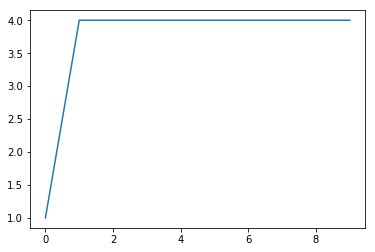

In [18]:
plt.plot(dfw)